# Author Notes

Summary - Imported dataset into kaggle, EDA on the dataset, Scaling the data, Test train split, Writing pytorch datasets and model. Training and then create a submission csv

In [ ]:
import pandas as pd
#Project Path - Data\train.csv
train_dataset = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
# train_dataset = train_dataset.sample(1000,random_state=11)//

In [2]:
from sklearn.model_selection import train_test_split
def split_dataset(dataset):
    target = 'loan_paid_back'
    trainset, tempset = train_test_split(dataset,test_size=0.3,stratify=dataset[target],random_state=11)
    valset, testset = train_test_split(tempset,test_size=0.5,stratify=tempset[target],random_state=11)
    print(len(dataset))
    print(len(trainset))
    print(len(valset))
    print(len(testset))
    
    return trainset, valset, testset

trainset, valset, testset = split_dataset(train_dataset)

593994
415795
89099
89100


In [3]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
def process_data(dataset,scaler=None,encoders=None,train=True):
    
    #Drop unnessary columns
    if 'id' in dataset.columns:
        dataset = dataset.drop('id',axis=1)
     
    num_cols = dataset.select_dtypes(include=['int64','float64']).columns.tolist()
    if 'loan_paid_back' in num_cols:
        num_cols.remove('loan_paid_back')
    cat_cols = dataset.select_dtypes(include=['object']).columns 
    
    if(train):

        #Scale the data with new scaler
        scaler = StandardScaler()
        dataset[num_cols] = scaler.fit_transform(dataset[num_cols])
        
        #Encode categorical data with new encoder
        encoders = {}
        for col in cat_cols:
            le = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
            dataset[[col]] = le.fit_transform(dataset[[col]])
            encoders[col] = le

    else:
        #Scale the data with fitted scaler
        dataset[num_cols] = scaler.transform(dataset[num_cols])
        
        #Encode categorical data with fitted encoder
        for col in cat_cols:
            dataset[[col]] = encoders[col].transform(dataset[[col]])

    return dataset, scaler, encoders
        
trainset,scaler,encoders = process_data(trainset,train=True)
valset,_,_ = process_data(valset,scaler,encoders,train=False)
testset,_,_ = process_data(testset,scaler,encoders,train=False)

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class loan_dataset(Dataset):
    def __init__(self, dataset, train=True):
        self.train = train 
        target = 'loan_paid_back'

        #train acts a submission flag
        if self.train:
            #Generate Labels
            X = dataset.drop(columns=[target]).values.astype('float32')
            self.features = torch.tensor(X, dtype=torch.float32)
            Y = dataset[target].values.astype('float32')
            self.labels = torch.tensor(Y, dtype=torch.float32)
        else:
            X = dataset.values.astype('float32')
            self.features = torch.tensor(X, dtype=torch.float32)
            self.labels = None  # No labels for inference
            
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        if self.train:
            return self.features[index], self.labels[index]
        else:
            return self.features[index]


In [6]:
traindataset = loan_dataset(trainset)
validationdataset = loan_dataset(valset)
testingdataset = loan_dataset(testset)

In [7]:
BATCH_SIZE = 32
trainerloader = DataLoader(traindataset,batch_size=BATCH_SIZE,shuffle=True)
valloader = DataLoader(validationdataset,batch_size=BATCH_SIZE,shuffle=False)
testloader = DataLoader(testingdataset,batch_size=BATCH_SIZE,shuffle=False)

In [8]:
class loan_predictor(nn.Module):
    def __init__(self,num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features,64),
            nn.ReLU(),
            nn.Linear(64,52),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(52,28),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(28,10),
            nn.ReLU(),
            nn.Linear(10,1)
        )
        
    def forward(self,x):
        return self.model(x);

In [9]:
EPOCH = 10
LEARNING_RATE = 1e-3
model = loan_predictor(11)
model = model.to(device)
from torch.optim import SGD
criterion = nn.BCEWithLogitsLoss()
from torch.optim import Adam
optimizer = Adam(model.parameters(), lr=LEARNING_RATE,  weight_decay=1e-4)


In [10]:
from tqdm import tqdm
import torch

loss_history = []
val_loss_history = []
test_loss_history = []

model.train()
for epoch in tqdm(range(EPOCH), desc="Epochs"):
    total_loss = 0
    
    # --- Training loop ---
    for features, labels in trainerloader:
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(trainerloader)
    loss_history.append(avg_train_loss)

    # --- Validation loop ---
    model.eval()  # Set model to eval mode
    val_loss = 0
    with torch.no_grad():  # Disable gradients
        for val_features, val_labels in valloader:
            val_features = val_features.to(device)
            val_labels = val_labels.to(device)
            
            val_outputs = model(val_features).squeeze(-1)
            val_loss += criterion(val_outputs, val_labels).item()
    
    avg_val_loss = val_loss / len(valloader)
    val_loss_history.append(avg_val_loss)

    # --- Optional: Test evaluation ---
    test_loss = 0
    with torch.no_grad():
        for test_features, test_labels in testloader:
            test_features = test_features.to(device)
            test_labels = test_labels.to(device)
            
            test_outputs = model(test_features).squeeze(-1)
            test_loss += criterion(test_outputs, test_labels).item()
    
    avg_test_loss = test_loss / len(testloader)
    test_loss_history.append(avg_test_loss)

    print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Test Loss={avg_test_loss:.4f}")

    model.train()  # Back to train mode for next epoch


Epochs:  10%|█         | 1/10 [00:31<04:39, 31.01s/it]

Epoch 1: Train Loss=0.2722, Val Loss=0.2648, Test Loss=0.2645


Epochs:  20%|██        | 2/10 [01:01<04:04, 30.55s/it]

Epoch 2: Train Loss=0.2647, Val Loss=0.2656, Test Loss=0.2652


Epochs:  30%|███       | 3/10 [01:31<03:32, 30.42s/it]

Epoch 3: Train Loss=0.2636, Val Loss=0.2611, Test Loss=0.2611


Epochs:  40%|████      | 4/10 [02:01<03:02, 30.43s/it]

Epoch 4: Train Loss=0.2629, Val Loss=0.2587, Test Loss=0.2587


Epochs:  50%|█████     | 5/10 [02:32<02:31, 30.39s/it]

Epoch 5: Train Loss=0.2623, Val Loss=0.2593, Test Loss=0.2595


Epochs:  60%|██████    | 6/10 [03:02<02:01, 30.36s/it]

Epoch 6: Train Loss=0.2618, Val Loss=0.2585, Test Loss=0.2588


Epochs:  70%|███████   | 7/10 [03:32<01:30, 30.24s/it]

Epoch 7: Train Loss=0.2615, Val Loss=0.2581, Test Loss=0.2580


Epochs:  80%|████████  | 8/10 [04:02<01:00, 30.21s/it]

Epoch 8: Train Loss=0.2612, Val Loss=0.2603, Test Loss=0.2604


Epochs:  90%|█████████ | 9/10 [04:32<00:30, 30.17s/it]

Epoch 9: Train Loss=0.2611, Val Loss=0.2615, Test Loss=0.2620


Epochs: 100%|██████████| 10/10 [05:02<00:00, 30.29s/it]

Epoch 10: Train Loss=0.2611, Val Loss=0.2600, Test Loss=0.2593


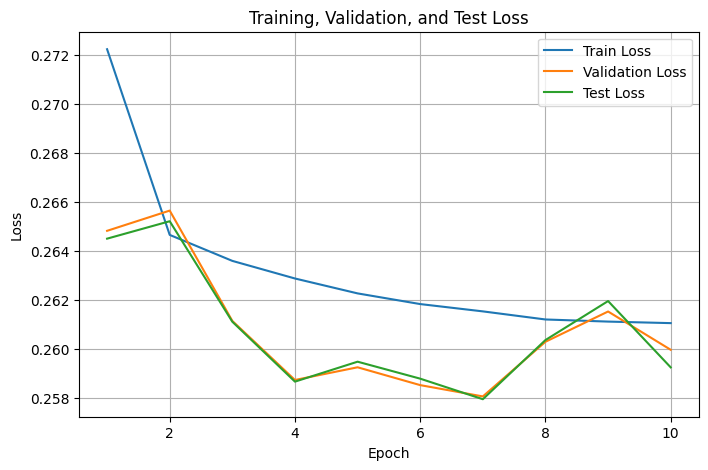

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss_history) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.plot(epochs, test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for features, labels in trainerloader:
        features, labels = features.to(device), labels.to(device)
        outputs = torch.sigmoid(model(features).squeeze(-1))
        preds = (outputs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Overfit accuracy: {correct/total:.4f}")

Overfit accuracy: 0.8994


In [13]:
features, labels = next(iter(trainerloader))
outputs = model(features.to(device)).squeeze(-1)
probs = torch.sigmoid(outputs)
preds = (probs >= 0.5).float()

print("Labels:", labels)
print("Raw outputs:", outputs)
print("Preds:", preds)


Labels: tensor([1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.])
Raw outputs: tensor([ 3.5250,  1.5614,  2.8930,  0.1631,  2.1013,  6.0932,  2.3578,  0.1795,
        -5.0897,  3.4354,  3.6718,  4.2092,  2.0912,  3.9003,  3.9268,  1.9471,
         2.1572,  2.9945,  0.7570,  3.9675,  2.7143,  2.2349,  3.2633,  2.6655,
         2.7913, -5.6459,  2.3775,  3.2911,  1.4482,  4.5830,  2.6542,  2.8137],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
Preds: tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')


# Submission

In [ ]:
#Project Path - Data\test.csv
eval_dataset = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")
eval_dataset = eval_dataset.iloc[:,:]

In [15]:
#submssion set
evalset,_,_ = process_data(eval_dataset,scaler,encoders,train=False)
evaldataset = loan_dataset(evalset, train=False)
evalloader = DataLoader(evaldataset,batch_size=BATCH_SIZE,shuffle=False)

In [16]:
import numpy as np
model.eval()
allpred = []
with torch.no_grad():
    for features in evalloader:
        preds = model(features.to(device))
        preds = torch.sigmoid(preds)
        preds = (preds >= 0.5).int().cpu()
        allpred.extend(preds.numpy())
allpred = np.array(allpred).astype(int)
flat_preds = [int(x) for x in allpred.reshape(-1)]        

In [17]:
submission = pd.DataFrame({
  "id":eval_dataset["id"],
    "loan_paid_back":flat_preds  
})
submission.to_csv("submission.csv",index=False)